# Analyze the results of the prediction
1. Generate the metadataset by running all cells in `create-metadataset.ipynb`
2. Run `train.py`. Make sure to use a config with the postprocessing step `VisualizationBlock`
3. Find the directory in `outputs/` that was created at the time you ran `train.py` and copy the path
4. Paste the path in the `RESULTS_PATH` variable below
5. View the plots, explore the tabels in your IDE, and view the images with the dashboard using their `tile_id`

In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RESULTS_PATH = Path('../outputs/2024-01-18/12-00-48/results.csv')

In [3]:
# Load the processed metadataset
metadataset = pd.read_csv('../data/processed/metadata.csv', index_col=0)
metadataset

,cloud,land,missing_landsat,kelp,in_train
tile_id,,,,,
JW725114,0.008294,0.142604,0.000000,0.000082,True
UX493605,0.004155,0.303135,0.000000,0.007404,True
OU500661,0.039673,0.254376,0.000000,0.000000,True
DC227980,0.009371,0.429110,0.000000,0.000000,True
SS602790,0.061763,0.837020,0.000000,0.000000,True
...,...,...,...,...,...
UT495238,0.297796,0.601306,0.296580,NaN,False
GE987629,0.307053,0.125967,0.307020,NaN,False
EN974536,0.348498,0.714710,0.348269,NaN,False


Load prediction results csv to analyze performance

In [4]:
# Load the prediction results
results = pd.read_csv(RESULTS_PATH, index_col=0)
results.head()

,sum_targets,sum_preds,intersections,dice_coef
image_key,,,,
ZZ649577,0,8.035920,0.0,0.0
JV369581,0,0.000635,0.0,0.0
UI581894,0,0.000201,0.0,0.0
JS758840,0,0.000503,0.0,0.0
JS667430,0,0.000676,0.0,0.0


Join the results with the metadata

In [5]:
results = metadataset.merge(results,left_index=True, right_index=True, how='inner')
results

,cloud,land,missing_landsat,kelp,in_train,sum_targets,sum_preds,intersections,dice_coef
JW725114,0.008294,0.142604,0.000000,0.000082,True,10,2944.753662,7.179494e+00,4.859623e-03
DC227980,0.009371,0.429110,0.000000,0.000000,True,0,0.000362,0.000000e+00,0.000000e+00
MW120705,0.033910,0.113918,0.000000,0.009755,True,1195,1306.899780,5.285189e+02,4.224941e-01
RO939398,0.004620,0.886694,0.000000,0.000065,True,8,29.181274,1.964861e+00,1.056909e-01
BE703016,0.000000,0.288906,0.000000,0.009290,True,1138,1064.395508,6.134796e+02,5.571021e-01
...,...,...,...,...,...,...,...,...,...
BU317954,0.418931,0.501029,0.418196,0.000041,True,5,38.724194,1.205773e-08,5.515358e-10
SJ916634,0.351665,0.422400,0.351665,0.001004,True,123,17.939913,4.034092e+00,5.724556e-02
JE368148,0.400857,0.242539,0.391820,0.004433,True,543,425.641205,2.768202e+02,5.715639e-01
XJ960525,0.389012,0.407224,0.292457,0.000000,True,0,0.000720,0.000000e+00,0.000000e+00


In [6]:
results['union'] = results['sum_targets'] + results['sum_preds']

# Compute error
Error is roughly "how much would our score increase if we had perfect predictions for this error"
Lower is better.

In [7]:
# compute error (difference between dice if prediction would've been perfect and actual dice)
total_intersection = results['intersections'].sum()
total_union = results['union'].sum()

perfect_dice = (2 * results['sum_targets'] + 2 * (total_intersection - results['intersections'])) / ((total_union - results['sum_preds'] - results['sum_targets']) + 2 * results['sum_targets'])
all_dice = (2 * total_intersection) / (total_union)
results['perfect_dice'] = perfect_dice
results["all_dice"] = all_dice
results['error'] = perfect_dice - all_dice
results["error_per"] = results['error'] * 100
results

,cloud,land,missing_landsat,kelp,in_train,sum_targets,sum_preds,intersections,dice_coef,union,perfect_dice,all_dice,error,error_per
JW725114,0.008294,0.142604,0.000000,0.000082,True,10,2944.753662,7.179494e+00,4.859623e-03,2954.753662,0.695229,0.694083,1.146706e-03,1.146706e-01
DC227980,0.009371,0.429110,0.000000,0.000000,True,0,0.000362,0.000000e+00,0.000000e+00,0.000362,0.694083,0.694083,1.408618e-10,1.408618e-08
MW120705,0.033910,0.113918,0.000000,0.009755,True,1195,1306.899780,5.285189e+02,4.224941e-01,2501.899780,0.694873,0.694083,7.906665e-04,7.906665e-02
RO939398,0.004620,0.886694,0.000000,0.000065,True,8,29.181274,1.964861e+00,1.056909e-01,37.181274,0.694098,0.694083,1.500501e-05,1.500501e-03
BE703016,0.000000,0.288906,0.000000,0.009290,True,1138,1064.395508,6.134796e+02,5.571021e-01,2202.395508,0.694642,0.694083,5.593006e-04,5.593006e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BU317954,0.418931,0.501029,0.418196,0.000041,True,5,38.724194,1.205773e-08,5.515358e-10,43.724194,0.694102,0.694083,1.872422e-05,1.872422e-03
SJ916634,0.351665,0.422400,0.351665,0.001004,True,123,17.939913,4.034092e+00,5.724556e-02,140.939913,0.694175,0.694083,9.247865e-05,9.247865e-03
JE368148,0.400857,0.242539,0.391820,0.004433,True,543,425.641205,2.768202e+02,5.715639e-01,968.641205,0.694335,0.694083,2.527014e-04,2.527014e-02
XJ960525,0.389012,0.407224,0.292457,0.000000,True,0,0.000720,0.000000e+00,0.000000e+00,0.000720,0.694083,0.694083,2.800179e-10,2.800179e-08


In [8]:
# Now lets filter the df on where sum_targets is larger than 0 and sort on asc dice coef

df_filter = results[results['kelp'] > 0]
print(len(results), len(df_filter))
df_filter = df_filter.sort_values(by='error', ascending=True)
df_filter.head(25)

1127 696


,cloud,land,missing_landsat,kelp,in_train,sum_targets,sum_preds,intersections,dice_coef,union,perfect_dice,all_dice,error,error_per
RG312186,0.002278,0.643208,0.000000,0.000008,True,1,0.000418,9.091143e-18,1.817469e-17,1.000418,0.694084,0.694083,7.320908e-07,0.000073
YN388134,0.424090,0.558751,0.422163,0.000008,True,1,0.000543,1.689851e-09,3.377867e-09,1.000543,0.694084,0.694083,7.321395e-07,0.000073
EQ795984,0.000000,0.778424,0.000000,0.000008,True,1,0.000758,1.068359e-15,2.135100e-15,1.000758,0.694084,0.694083,7.322229e-07,0.000073
DD803154,0.005143,0.305543,0.388294,0.000016,True,2,0.000256,3.822088e-09,3.821600e-09,2.000256,0.694084,0.694083,1.463955e-06,0.000146
PG864148,0.002098,0.769241,0.000000,0.000016,True,2,0.000613,5.656174e-10,5.654441e-10,2.000613,0.694084,0.694083,1.464094e-06,0.000146
GY748314,0.000000,0.601078,0.000000,0.000016,True,2,0.036469,4.444497e-03,4.364905e-03,2.036469,0.694084,0.694083,1.473060e-06,0.000147
YW449477,0.000000,0.585869,0.000000,0.000008,True,1,3.337120,8.133460e-13,3.750627e-13,4.337120,0.694085,0.694083,2.030115e-06,0.000203
XW500536,0.073355,0.109731,0.000000,0.000033,True,4,0.000156,1.932816e-12,9.663703e-13,4.000156,0.694086,0.694083,2.927768e-06,0.000293
YA891196,0.055086,0.314278,0.804890,0.000033,True,4,0.000161,2.039033e-07,1.019475e-07,4.000161,0.694086,0.694083,2.927770e-06,0.000293
AJ626598,0.103853,0.010237,0.000008,0.000033,True,4,0.000199,8.658785e-09,4.329177e-09,4.000199,0.694086,0.694083,2.927785e-06,0.000293


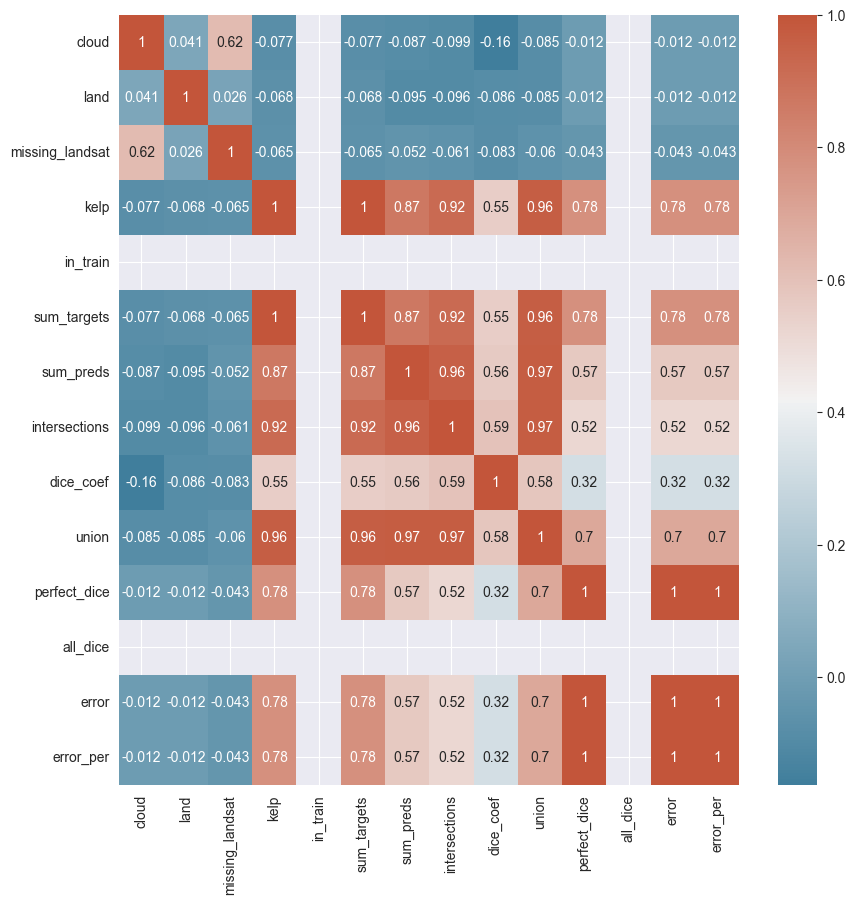

In [9]:
# Plot the correlation matrix with sns

#Use a good colormap 
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
corr = results.corr()
sns.heatmap(corr, annot=True, cmap=cmap, ax=ax)
plt.show()

# Plots against error

### Do we predict too much or too little kelp?


917814.059392682 866400
In total we predict 105.93421738142683% of the true kelp in the dataset
Kelp in dataset: 0.627564601705811%
TP: 619196.1333101417, FP: 298617.9260825402, FN: 247203.86668985826, TN: 136988482.52661794


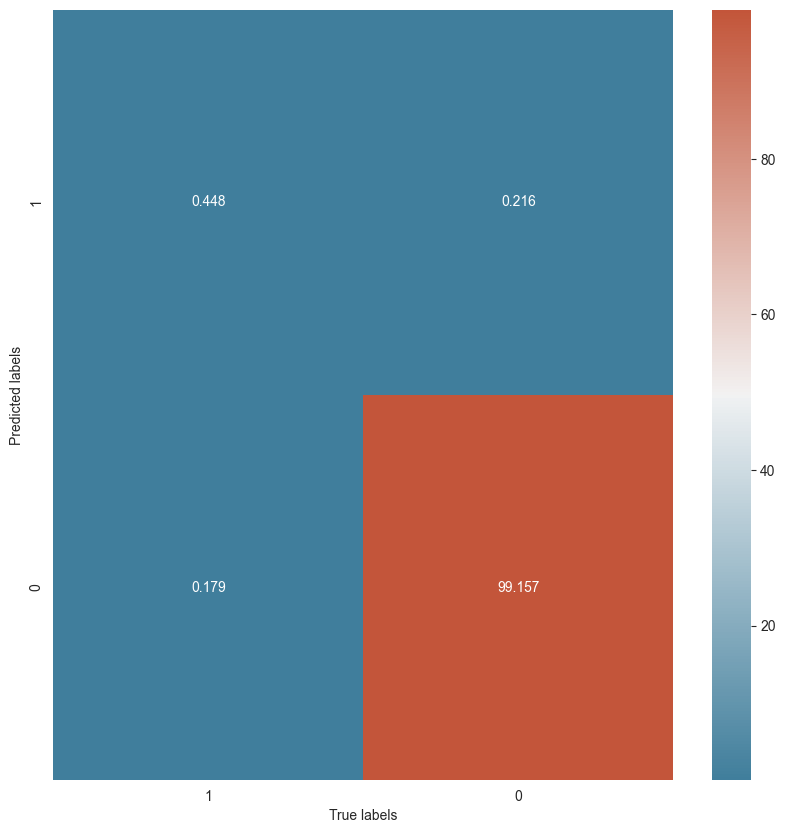

In [10]:
total_predicted = results['sum_preds'].sum()
total_actual = results['sum_targets'].sum()
print(total_predicted, total_actual)
# Print as a percentage

print(f"In total we predict {total_predicted / total_actual * 100}% of the true kelp in the dataset")
print(f"Kelp in dataset: {total_actual / (350 * 350 * len(results)) * 100}%")

results["TP"] = results["intersections"]
a = (350 * 350) - results["sum_preds"]
b = (350 * 350) - results["sum_targets"]
#Set results TN to the min(a,b)
results["TN"] = a.where(a < b, b)
results["FP"] = results["sum_preds"] - results["intersections"]
results["FN"] = results["sum_targets"] - results["intersections"]

#Print the sum of the confusion matrix with annotation f string
print(f"TP: {results['TP'].sum()}, FP: {results['FP'].sum()}, FN: {results['FN'].sum()}, TN: {results['TN'].sum()}")


# Create the confusion matrix from the results
#Print in a nice format rounded by 3 decimals
confusion_matrix = results[['TP', 'FP', 'FN', 'TN']].sum().values.reshape(2,2)
# Print the confusion matrix using seaborn in float with 3 decimals

#Print the one with percentages on the right

confusion_matrix_perc = (confusion_matrix / confusion_matrix.sum()) * 100
fig, ax = plt.subplots(figsize=(10,10))

#Name the axis correctly to the format of a heatmap with TP, FP, FN, TN

sns.heatmap(confusion_matrix_perc, annot=True, fmt='.3f', cmap=cmap)
#Add correct predictions and labels to the confusion matrix axes
# Set x axis to 0,1
ax.set_xticklabels([1,0])
ax.set_yticklabels([1,0])
ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')



plt.show()





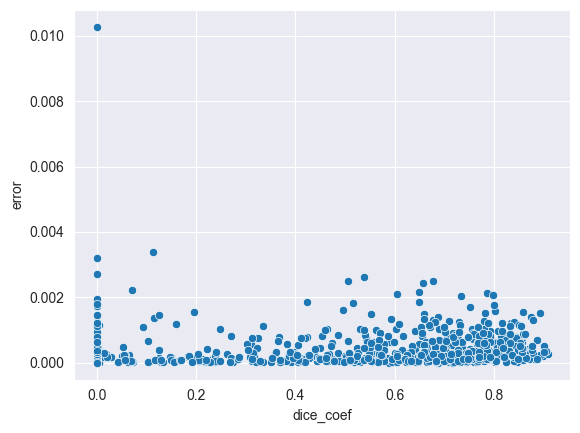

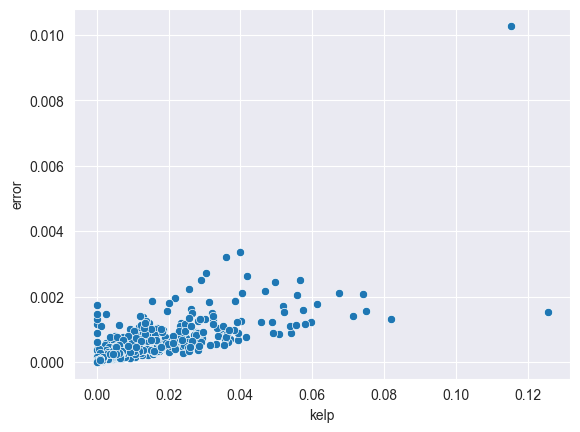

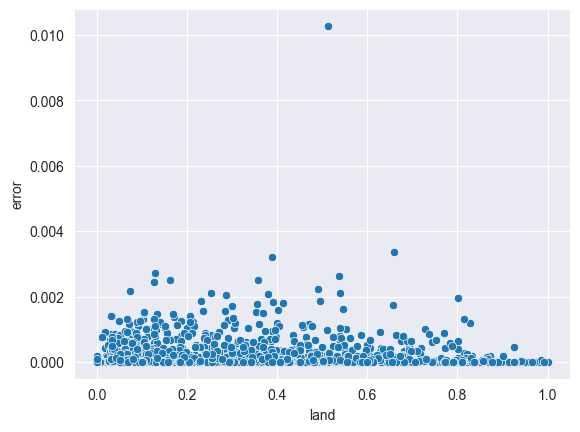

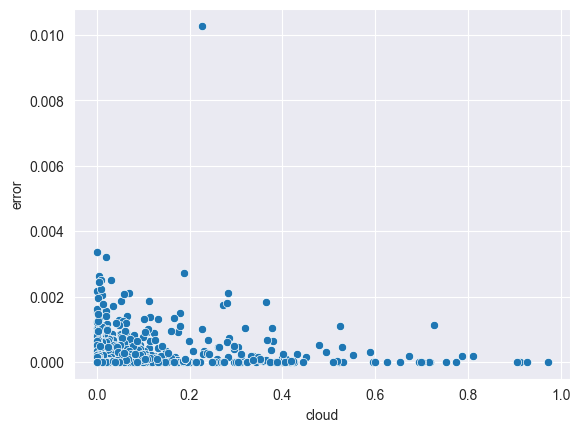

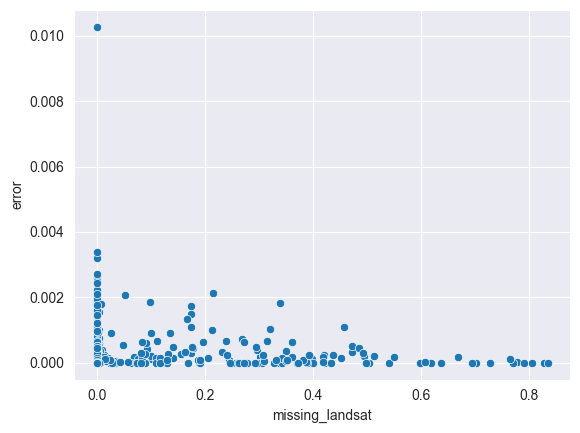

In [11]:
# Plot scatterplots of error
for col in ['dice_coef','kelp', 'land', 'cloud', 'missing_landsat']:
    sns.scatterplot(data=results, x=col, y='error')
    plt.show()

# Plots against dice coef

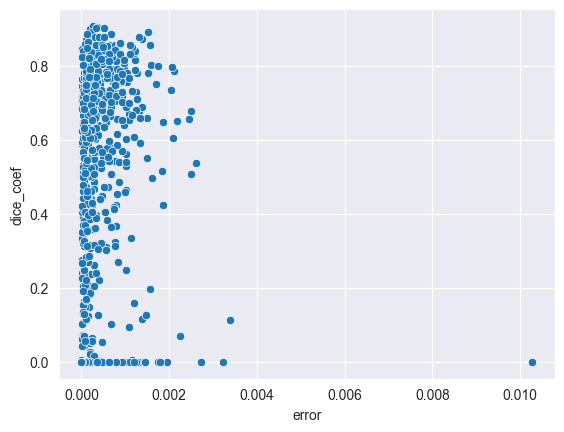

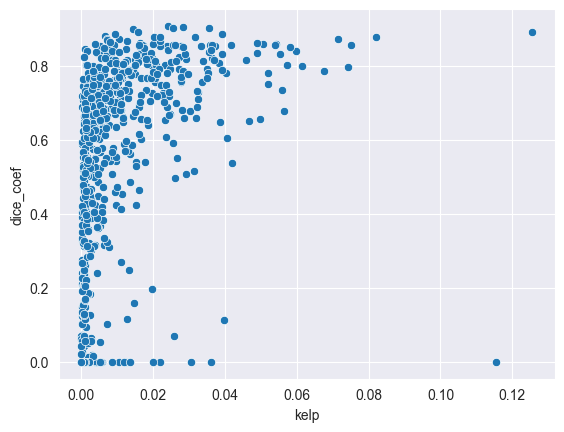

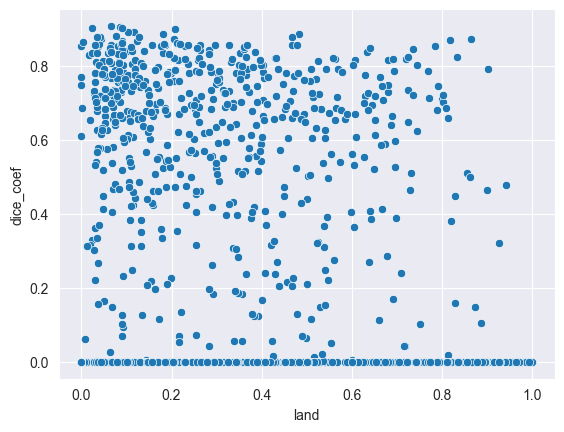

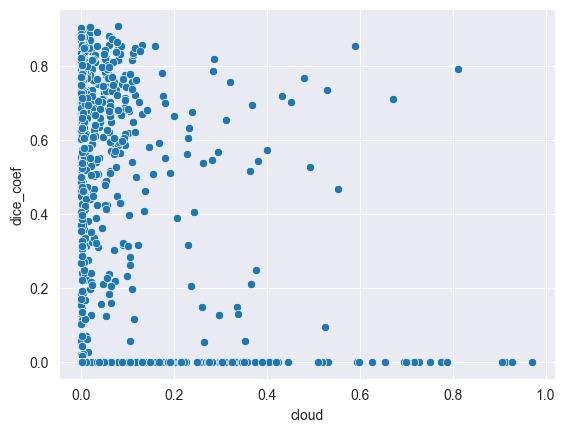

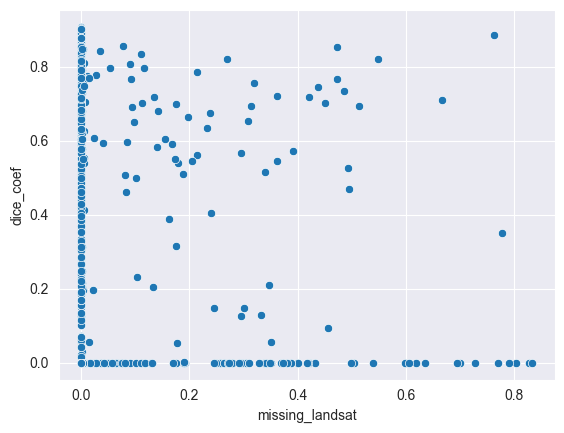

In [12]:
for col in ['error','kelp', 'land', 'cloud', 'missing_landsat']:
    sns.scatterplot(data=results, x=col, y='dice_coef')
    plt.show()

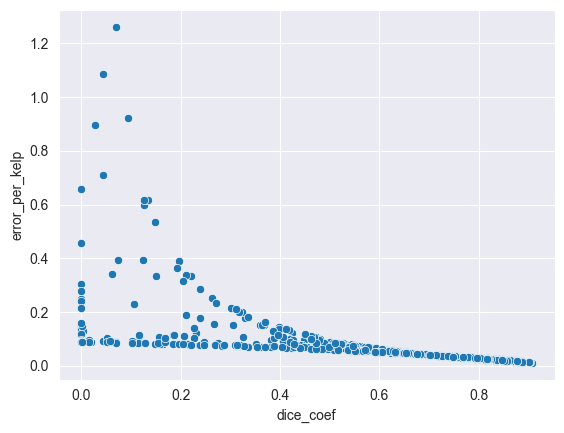

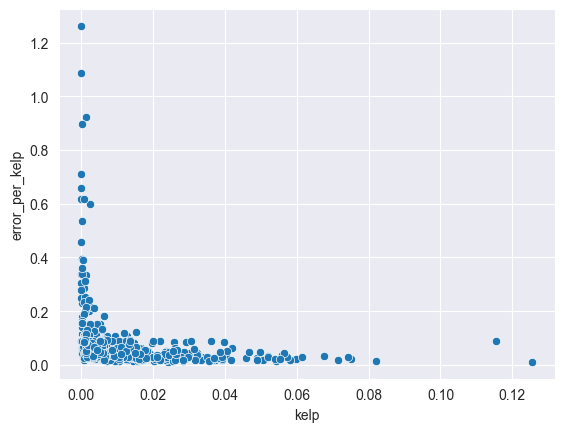

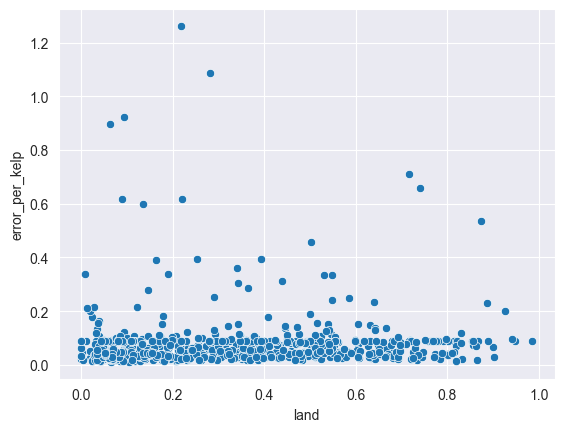

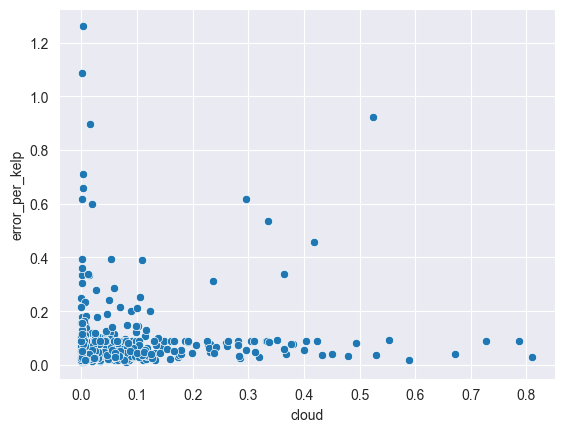

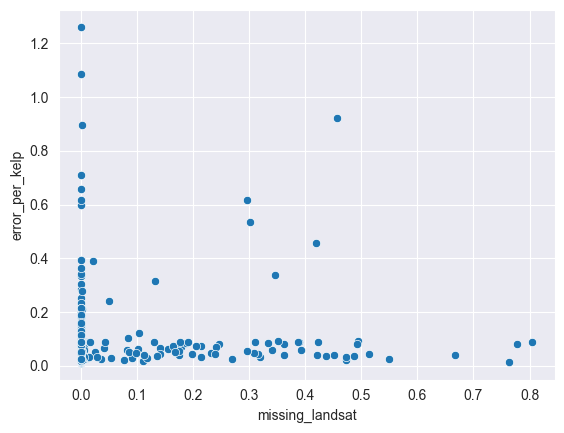

In [13]:
# There is a clear correlation between error and kelp. 
# Create a new column that is the error divided by kelp
# Then make the plots against error again
results['error_per_kelp'] = results['error'] / results['kelp']


# remove outliers with an error_per_kelp larger than n stds
n = 2
results_clean = results[results['kelp'] > 0]
mean = results_clean['error_per_kelp'].mean()
stds = results_clean['error_per_kelp'].std()
results_clean = results_clean[results_clean['error_per_kelp'] < mean + n*stds]


for col in ['dice_coef','kelp', 'land', 'cloud', 'missing_landsat']:
    
    sns.scatterplot(data=results_clean, x=col, y='error_per_kelp')
    plt.show()